#***Module import***

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans as SklearnKMeans
from mpl_toolkits.mplot3d import Axes3D
import time


#***Data Import***

In [16]:
df = pd.read_csv("/content/sample_data/Mall_Customers.xls")
print("First 5 rows:")
display(df.head())

First 5 rows:


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
print("\nDataset Info:")
df.info()
print("\nMissing Values:\n", df.isnull().sum())
df = df.dropna()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Missing Values:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [17]:
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

#normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#statsummary
print("\nSummary Statistics:")
display(pd.DataFrame(X, columns=['Age','Income','Spending']).describe())


Summary Statistics:


,Age,Income,Spending
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


# ***Initial Plots***

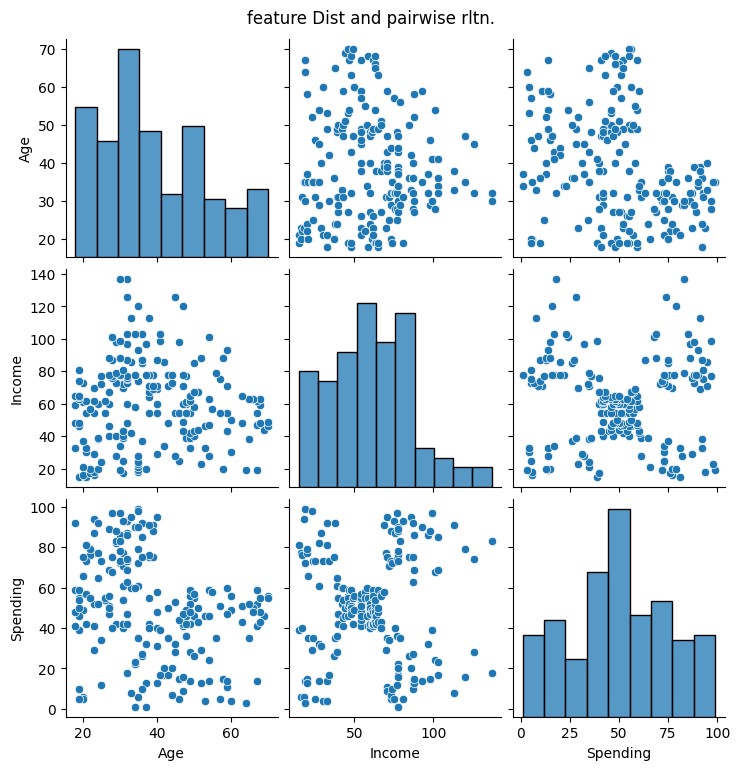

In [37]:
sns.pairplot(pd.DataFrame(X, columns=['Age','Income','Spending']))
plt.suptitle("feature Dist and pairwise rltn.", y=1.02)
plt.show()


# ***K-means from scratch***




In [19]:
def initialize_centroids(X, k, random_state=None):
    np.random.seed(random_state)
    indices = np.random.choice(len(X), k, replace=False)
    return X[indices]

def kmeans_plus_plus_init(X, k, random_state=None):
    np.random.seed(random_state)
    centroids = []
    centroids.append(X[np.random.randint(X.shape[0])])
    for _ in range(1, k):
        dist_sq = np.min([np.sum((X - c) ** 2, axis=1) for c in centroids], axis=0)
        probs = dist_sq / np.sum(dist_sq)
        cumulative_probs = np.cumsum(probs)
        r = np.random.rand()
        for j, p in enumerate(cumulative_probs):
            if r < p:
                centroids.append(X[j])
                break
    return np.array(centroids)


def assign_clusters(X, centroids):
    distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
    return np.argmin(distances, axis=0)

#updcentroid
def update_centroids(X, labels, k):
    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

#kmeans
def kmeans(X, k, max_iters=100, tol=1e-4, random_state=None, init_method='random'):
    if init_method == 'kmeans++':
        centroids = kmeans_plus_plus_init(X, k, random_state)
    else:
        centroids = initialize_centroids(X, k, random_state)

    for i in range(max_iters):
        old_centroids = centroids.copy()
        labels = assign_clusters(X, centroids)
        centroids = update_centroids(X, labels, k)
        if np.linalg.norm(centroids - old_centroids) < tol:
            break

    inertia = np.sum([np.min(np.sum((X - c)**2, axis=1)) for c in centroids])
    return centroids, labels, i+1, inertia

# ***Choosing optimal K***

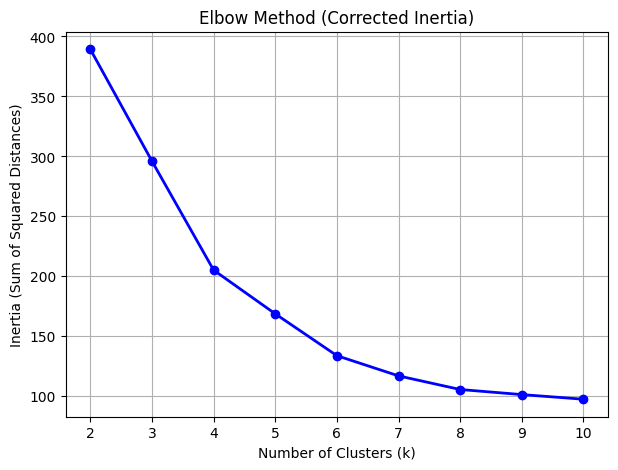

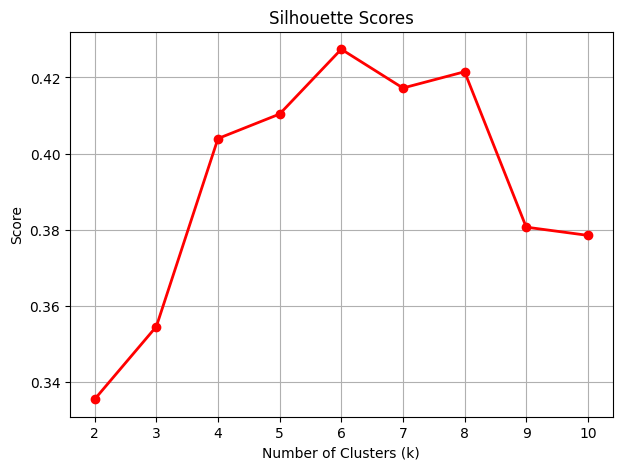

In [39]:

def compute_inertia(X, centroids, labels):
    inertia = 0
    for i in range(len(centroids)):
        cluster_points = X[labels == i]
        inertia += np.sum((cluster_points - centroids[i])**2)
    return inertia

inertias = []
sil_scores = []
K = range(2, 11)

for k in K:
    centroids, labels, iters, _ = kmeans(X_scaled, k, init_method='kmeans++', random_state=42)
    inertia = compute_inertia(X_scaled, centroids, labels)
    inertias.append(inertia)
    sil_scores.append(silhouette_score(X_scaled, labels))

#elbow.plt()
plt.figure(figsize=(7,5))
plt.plot(K, inertias, 'bo-', linewidth=2)
plt.title('Elbow Method (Corrected Inertia)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)
plt.show()

#silhouette.plt()
plt.figure(figsize=(7,5))
plt.plot(K, sil_scores, 'ro-', linewidth=2)
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.grid(True)
plt.show()


In [40]:
#Choosing optimal K
optimal_k = 6
print(f"Chosen k = {optimal_k}")

Chosen k = 6


# ***Applying the Algo***


Final Centroids (Standardized):
[[ 1.25472096 -0.24021294 -0.04399777]
 [-0.44191719  0.99158305  1.23950275]
 [-0.97602698 -1.32549704  1.0371827 ]
 [ 0.22171558  1.08322527 -1.29005223]
 [-0.87309844 -0.11378508 -0.09358039]
 [ 0.47895722 -1.30822992 -1.19644353]]

Iterations: 10, Inertia: 0.3014649555772244

Cluster Averages:
                Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        56.333333           54.266667               49.066667
1        32.692308           86.538462               82.128205
2        25.250000           25.833333               76.916667
3        41.939394           88.939394               16.969697
4        26.684211           57.578947               47.789474
5        45.523810           26.285714               19.380952


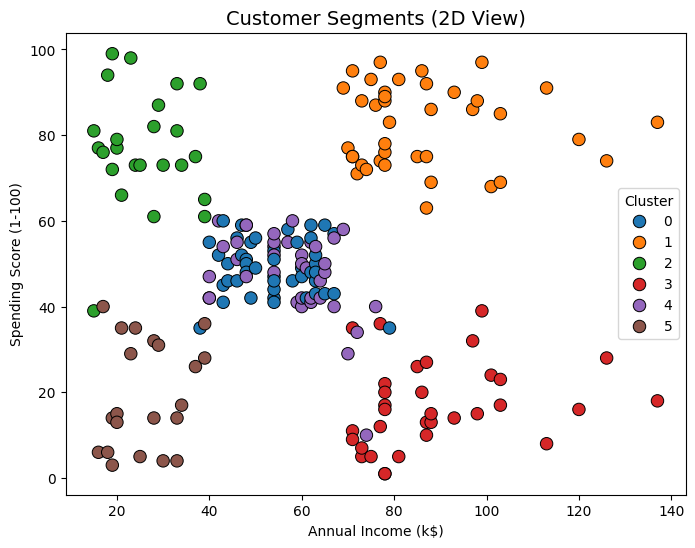

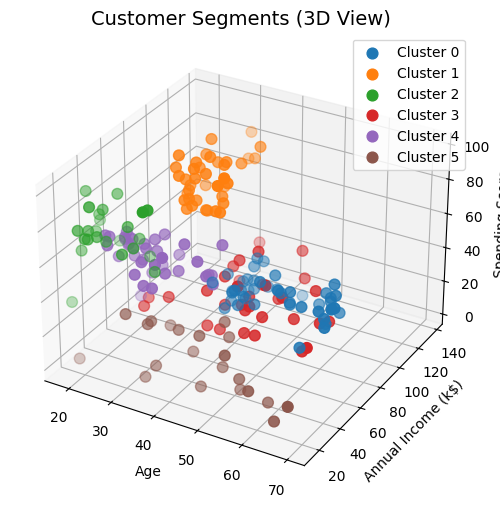

In [41]:
centroids, labels, iters, inertia = kmeans(X_scaled, optimal_k, init_method='kmeans++', random_state=42)
df['Cluster'] = labels

print(f"\nFinal Centroids (Standardized):\n{centroids}")
print(f"\nIterations: {iters}, Inertia: {inertia}")

# Cluster statistics
cluster_summary = df.groupby('Cluster')[['Age','Annual Income (k$)','Spending Score (1-100)']].mean()
print("\nCluster Averages:\n", cluster_summary)

plt.figure(figsize=(8,6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Cluster', data=df, palette='tab10', s=80, edgecolor='black')
plt.title('Customer Segments (2D View)', fontsize=14)
plt.show()

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
colors = sns.color_palette("tab10", n_colors=optimal_k)

for i in range(optimal_k):
    cluster_points = df[df['Cluster'] == i]
    ax.scatter(cluster_points['Age'], cluster_points['Annual Income (k$)'],
               cluster_points['Spending Score (1-100)'], color=colors[i],
               s=60, label=f'Cluster {i}')

ax.set_title('Customer Segments (3D View)', fontsize=14)
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score')
ax.legend()
plt.show()



# ***Comparing with scikit learn***


--- sklearn KMeans Comparison ---
Centroids (Standardized):


,Age,Income,Spending
0,1.178830,-0.493886,-0.329716
1,-0.428806,0.974847,1.216085
2,-0.938764,-1.314731,0.956802
3,-0.869573,-0.238517,-0.360609
4,0.397379,1.115089,-1.231270


Inertia: 169.89
Iterations: 7
Runtime: 0.0090 seconds


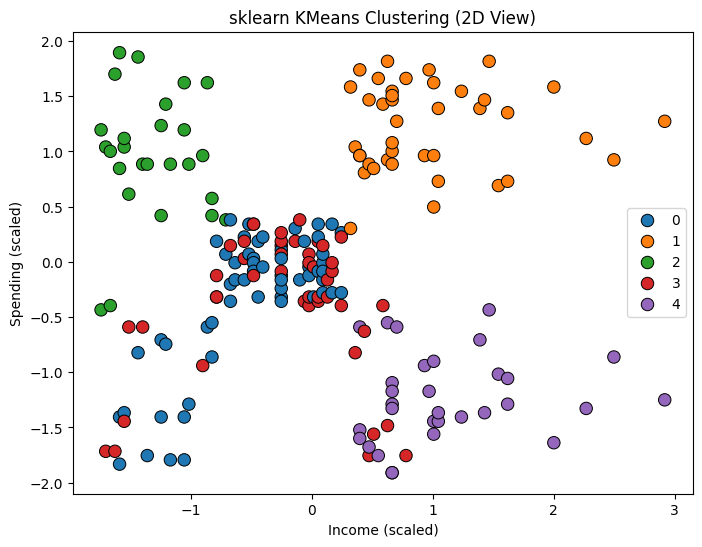

In [26]:
start = time.time()
sk_kmeans = SklearnKMeans(n_clusters=optimal_k, random_state=42)
sk_labels = sk_kmeans.fit_predict(X_scaled)
end = time.time()

print("\n--- sklearn KMeans Comparison ---")
print("Centroids (Standardized):")
display(pd.DataFrame(sk_kmeans.cluster_centers_, columns=['Age','Income','Spending']))
print(f"Inertia: {sk_kmeans.inertia_:.2f}")
print(f"Iterations: {sk_kmeans.n_iter_}")
print(f"Runtime: {end - start:.4f} seconds")

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_scaled[:,1], y=X_scaled[:,2], hue=sk_labels, palette='tab10', s=80, edgecolor='black')
plt.title('sklearn KMeans Clustering (2D View)')
plt.xlabel('Income (scaled)')
plt.ylabel('Spending (scaled)')
plt.show()



# ***General Interpretations***

In [36]:
print("ClusterInfo")
for i, row in cluster_summary.iterrows():
    age, income, spend = row
    desc = []
    if age < 35: desc.append("Young")
    elif age < 50: desc.append("MiddleAged")
    else: desc.append("Older")

    if income > df['Annual Income (k$)'].mean(): desc.append("High income")
    else: desc.append("Low income")

    if spend > df['Spending Score (1-100)'].mean(): desc.append("High spender")
    else: desc.append("Low spender")

    print(f"Cluster {i}: {', '.join(desc)}")

ClusterInfo
Cluster 0: Older, Low income, Low spender
Cluster 1: Young, High income, High spender
Cluster 2: Young, Low income, High spender
Cluster 3: MiddleAged, High income, Low spender
Cluster 4: Young, Low income, Low spender
